In [4]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [5]:
def f(x, y):
    "Objective function"
    return (x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)

In [6]:
def levy_step(mu=1.5):
    """Generate a step length from a Levy distribution."""
    return np.random.pareto(mu) + 1  # Using Pareto distribution for Levy flight

In [16]:
for i in range(20):
    print(levy_step(1.5))

1.033607432693296
1.1900997479278896
1.1330564820809164
1.6143385593573343
1.0299147021495587
2.298009560584868
7.572726122687182
2.050618380001341
1.552902773321874
1.0998392496648126
1.241266554489502
1.0280299730769882
1.070053557235126
1.9878230718795595
1.2078427980077957
1.8080102125939255
1.3480244982957807
3.394005781847542
1.1331505551022654
5.202570998207265


In [82]:
class Particle:
    def __init__(self, env, name, particles, X=np.array([0.1, 0.1]), target = np.array([2.5,2.5]), c1=0.5, c2=0.5, w=0.8):
        self.env = env
        self.name = name
        self.particles = particles  # List of all particles
        self.c1 = c1
        self.c2 = c2
        self.w = w
        self.speed = 0.015433 # 3 knots

        self.X = X
        self.target = target
        self.V = (target/np.linalg.norm(target)) * 1
        self.pbest_position = self.X.copy()
        self.pbest_fitness = f(self.X[0], self.X[1])

        self.nbest_position = self.X.copy()
        self.nbest_fitness = self.pbest_fitness

        self.positions = [self.X.copy()]

        self.process = env.process(self.run())

    def interact(self):
        """Interact with other particles based on proximity."""
        for particle in self.particles:
            if particle != self:
                distance = np.linalg.norm(self.X - particle.X) # Euclidean distance
                if distance < 1.0:  # Interaction threshold
                #    self.V += (self.X - particle.X) * 0.1  # Example interaction: repulsion
                    particle.receive(self.nbest_position, self.nbest_fitness)

    def receive(self, nbest_position, nbest_fitness):
        """update the personal nbest"""
        if nbest_fitness < self.nbest_fitness:
            self.nbest_position = nbest_position.copy()
            self.nbest_fitness = nbest_fitness
    
    def update(self):
        r1, r2 = np.random.rand(2)
        self.w = levy_step(1.5)
        self.V = self.w * self.V + self.c1 * r1 * (self.pbest_position - self.X) + self.c2 * r2 * (self.nbest_position - self.X)
        self.target = self.X + self.V

    def sensing(self):
        fitness = f(self.X[0], self.X[1])

        if fitness < self.pbest_fitness:
            self.pbest_position = self.X.copy()
            self.pbest_fitness = fitness

        if fitness < self.nbest_fitness:
            self.nbest_position = self.X.copy()
            self.nbest_fitness = fitness

    def move(self):
        hy = np.linalg.norm(self.V)
        self.X = self.X + self.speed * (self.V / hy)
        distance = np.linalg.norm(self.X - self.target) # Euclidean distance
        if distance <= 0.03:  # Interaction threshold
            self.update()
            print(self.name," Updated! ", self.V, " nbest_loc ", self.nbest_position, " nbest_fit ", self.nbest_fitness)

    def run(self):
        i = 0
        while True:
            self.sensing()
            self.move()
            if i%5 ==0:
                self.interact()  # Interact with other particles after updating
                self.positions.append(self.X.copy()) # take the records of position
                # print("Name: ", self.name, "Target: ", self.X)
            i = i + 1
            yield self.env.timeout(1)

In [85]:
def initialize_grid_particles(n_particles, bounds):
    """Evenly distribute particles on a grid within the search space."""
    list_particles = []
    
    # Determine the number of rows and columns based on the number of particles
    n_side = int(np.ceil(np.sqrt(n_particles)))  # Number of rows and columns in the grid
    x_coords = np.linspace(0, bounds, n_side)
    y_coords = np.linspace(0, bounds, n_side)

    # Create particles and assign grid positions
    for i in range(n_particles):
        # Calculate grid coordinates (i.e., row and column)
        row = i // n_side
        col = i % n_side
        grid_position = (x_coords[col], y_coords[row])  # Assign grid position
        list_particles.append(grid_position)
    
    return list_particles

# Example of how to initialize and simulate particles
bounds = 5  # Bounds of the search space
n_particles = 20  # Number of particles
list_particles = initialize_grid_particles(n_particles, bounds)

print(list_particles)

[(0.0, 0.0), (1.25, 0.0), (2.5, 0.0), (3.75, 0.0), (5.0, 0.0), (0.0, 1.25), (1.25, 1.25), (2.5, 1.25), (3.75, 1.25), (5.0, 1.25), (0.0, 2.5), (1.25, 2.5), (2.5, 2.5), (3.75, 2.5), (5.0, 2.5), (0.0, 3.75), (1.25, 3.75), (2.5, 3.75), (3.75, 3.75), (5.0, 3.75)]


In [83]:
def simulate_pso():
    env = simpy.Environment()
    n_particles = 20

    particles = [Particle(env, f'Particle {i}', []) for i in range(n_particles)]
    for particle in particles:
        particle.particles = particles  # Give each particle the list of all particles

    global_best = particles[0]
    
    def update_nbest():
        while True:
            global_best = min(particles, key=lambda p: p.pbest_fitness)
            # for particle in particles:
            #     particle.nbest_position = global_best.pbest_position
            #     particle.nbest_fitness = global_best.pbest_fitness
            yield env.timeout(1)

    env.process(update_nbest())
    env.run(until=500)

    return [p.positions for p in particles], global_best.pbest_position, global_best.pbest_fitness

In [84]:
positions, nbest, nbest_obj = simulate_pso()

Particle 0  Updated!  [1.53964938 1.53964938]  nbest_loc  [2.46807303 2.46807303]  nbest_fit  2.0470041105998966
Particle 1  Updated!  [2.03035616 2.03035616]  nbest_loc  [2.46807303 2.46807303]  nbest_fit  2.0470041105998966
Particle 2  Updated!  [1.59953126 1.59953126]  nbest_loc  [2.46807303 2.46807303]  nbest_fit  2.0470041105998966
Particle 3  Updated!  [0.72665499 0.72665499]  nbest_loc  [2.46807303 2.46807303]  nbest_fit  2.0470041105998966
Particle 4  Updated!  [0.82971814 0.82971814]  nbest_loc  [2.46807303 2.46807303]  nbest_fit  2.0470041105998966
Particle 5  Updated!  [0.71201547 0.71201547]  nbest_loc  [2.46807303 2.46807303]  nbest_fit  2.0470041105998966
Particle 6  Updated!  [0.75381942 0.75381942]  nbest_loc  [2.46807303 2.46807303]  nbest_fit  2.0470041105998966
Particle 7  Updated!  [7.55915368 7.55915368]  nbest_loc  [2.46807303 2.46807303]  nbest_fit  2.0470041105998966
Particle 8  Updated!  [0.89887291 0.89887291]  nbest_loc  [2.46807303 2.46807303]  nbest_fit  2.

In [63]:
for i in positions:
    print(i)

[array([0.1, 0.1]), array([0.08760984, 0.10920117]), array([0.02565905, 0.155207  ]), array([-0.03629174,  0.20121284]), array([-0.09824253,  0.24721867]), array([-0.16019332,  0.29322451]), array([-0.22214411,  0.33923034]), array([-0.2840949 ,  0.38523618]), array([-0.34604569,  0.43124201]), array([-0.40799648,  0.47724785]), array([-0.46994727,  0.52325368]), array([-0.53189806,  0.56925952]), array([-0.59384885,  0.61526535]), array([-0.65579964,  0.66127119]), array([-0.71775043,  0.70727702]), array([-0.77970122,  0.75328286]), array([-0.84165201,  0.79928869]), array([-0.9036028 ,  0.84529453]), array([-0.96555359,  0.89130036]), array([-1.02750438,  0.9373062 ]), array([-1.08945517,  0.98331203])]
[array([0.1, 0.1]), array([0.10805668, 0.11316311]), array([0.14834008, 0.17897864]), array([0.18862349, 0.24479418]), array([0.22890689, 0.31060971]), array([0.26919029, 0.37642525]), array([0.30947369, 0.44224078]), array([0.3497571 , 0.50805632]), array([0.3900405 , 0.57387185]), 

MovieWriter imagemagick unavailable; using Pillow instead.


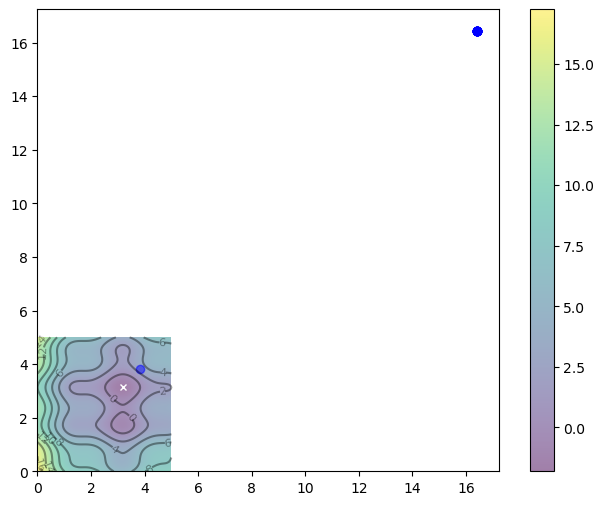

DPSO found best solution at f([3.15557811 3.15557811])=-1.7976491032407806


In [78]:
# Plotting and Animation
x, y = np.array(np.meshgrid(np.linspace(0, 5, 100), np.linspace(0, 5, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

def animate(i):
    ax.clear()
    ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
    ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
    contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    for pos in positions:
        p_plot = ax.scatter(pos[i][0], pos[i][1], marker='o', color='blue', alpha=0.5)
    nbest_plot.set_offsets(nbest.reshape(1, -1))
    return ax, p_plot, nbest_plot

anim = FuncAnimation(fig, animate, frames=len(positions[0]), interval=500, blit=False, repeat=True)
anim.save("PSO.gif", dpi=120, writer="imagemagick")
plt.show()

print("DPSO found best solution at f({})={}".format(nbest, nbest_obj))
